# Full Correlation Matrix Analysis

The connectivity analyses we performed previously examined the coupling of different regions of the brain. This coupling can capture information that activity-based univariate or multivariate techniques do not detect. For instance, imagine that voxel A and B are coupled during one task condition,  whereas voxel A and C are coupled during another task condition. In such a case, voxel A may always be active (and thus task differences are likely to be invisible to activity-based approaches _including MVPA_), but its connectivity with other voxels will reveal task information.

However, this creates a problem: to find which voxels are task-diagnostic in an unbiased, data-driven fashion, it is necessary to correlate every voxel in the brain with every other voxel, then somehow analyze these millions or billions of pairwise correlations. This computation can take a very long time. There are assumptions we can use to simplify the complexity of this analysis, such as downsampling the voxels (e.g., using parcellation as in the previous session) to reduce the total number of correlations that are made. In doing so, though, we introduce the assumption that those parcellations divide the brain into functionally meaningful units.

Fortunately, advances in machine learning, parallel computing, and efficient coding have made it possible to calculate and analyze billions of correlations rapidly. These tools are part of the [BrainIAK toolbox](http://brainiak.org/) and are used for Full Correlation Matrix Analysis (FCMA). This method is outlined in detail in [Wang et al. (2015)](http://ntblab.yale.edu/wp-content/uploads/2015/06/Wang_JNM_2015.pdf). In what follows we will learn how to run FCMA and then actually perform it on real data, speeding up our analyses by submitting jobs on SLURM.

The logic of FCMA is as follows: take the activity of every voxel in the brain and correlate it with the activity of every other voxel in the brain. Repeat this process for each participant and trial to get a full correlation matrix per participant per trial. Then, take each matrix and turn it into a (condensed) vector, so that every pairwise relationship is represented as an element in that vector. This vector is a list of features that can be used for classification, just like we used voxels or principal components in past exercises. The vectors for each trial/condition can then be stacked so that we get an example-by-feature matrix. We can then feed that matrix into a classifier and determine whether the pattern of information across voxel pairs discriminates between conditions.  

We will use FCMA to determine if there exist brain regions, undetectable by MVPA, that show differential processing of attending to faces vs. scenes. We can compare our results from FCMA to the MVPA results that were generated in the searchlight notebook.


## Goal of this script
1. Run FCMA feature selection
2. Run FCMA classification
3. Learn plotting tools for FCMA

## Table of Contents
[1. The FCMA workflow](#fcma_wf)  
>[1.1 Data preparation](#data_prep)  
>[1.2 Create an epoch file](#epoch)  
>[1.3 Normalize data](#prep_for_fcma)  
>[1.4 Compute correlations and voxel selection](#vox_sel)  
>[1.5 Create voxel selection masks](#masks)  
>[1.6 Classification](#classify)  
>>[1.6.1 Pre-computed kernel](#precomputed) 

[2. FCMA batch scripts](#fcma_batch)
>[2.1 Inner loop (three subjects)](#fcma_inner)  
>[2.2 Outer loop (all subjects)](#fcma_outer)  
>[2.3 Permutation testing](#fcma_perm)  

[3. Plotting the results](#plot) 
>[3.1 Plot the connectome](#connectome)  
>[3.2 Plotting circos](#circos)  

[4. MVPA and FCMA](#mvpa) 

### Exercises:  
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)  [9](#ex9) 
>[Novel contribution](#novel) 


### Dataset <a id="data-set"></a> 

For this script we will use the face/scene dataset from [Wang et al. (2015)](https://doi.org/10.1016/j.jneumeth.2015.05.012), who in turn used localizer data from [Turk-Browne et al. (2012)](https://doi.org/10.1523/JNEUROSCI.0942-12.2012). Localizer details from Turk-Browne et al. (2012):

"Subjects also completed a functional localizer run lasting 6 min 6 s to define bilateral PPA regions of interest (ROIs). An ROI approach was used to minimize multiple comparisons and improve statistical power. The localizer run alternated between six repetitions each of scene and face blocks (Turk-Browne et al., 2010). Blocks contained 12 stimuli presented for 500 ms every 1500 ms. The 18 s of stimulation was followed by 12 s of fixation before the next block. Subjects made the same indoor/outdoor judgment for scenes, and a male/female judgment for faces."

**Self-study:** Explore the data

In [3]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# Import libraries
import nibabel as nib
import numpy as np
import time
import os
from scipy.stats import sem

from nilearn import plotting
from nilearn.image import coord_transform

import brainiak.utils.fmrisim as sim
from brainiak.fcma.voxelselector import VoxelSelector
from brainiak.fcma.preprocessing import prepare_fcma_data
from brainiak.fcma.preprocessing import RandomType
from brainiak.fcma.util import compute_correlation
from brainiak import io

import networkx as nx
import nxviz as nv

import matplotlib.pyplot as plt
import seaborn as sns 

sns.set(style = 'white', context='notebook', rc={"lines.linewidth": 2.5})


## 1. The FCMA workflow <a id="fcma_wf"></a>

The following sequence of steps are necessary for successfully running FCMA using BrainIAK. 

1. [Data preparation](#data_prep) 

2. [Create an epoch file](#epoch)
    
3. [Normalize data](#prep_for_fcma) 

4. [Correlation and voxel selection](#vox_sel)

5. [Create voxel selection masks](#masks)

6. [Classification](#classify)

### 1.1 Data preparation <a id="data_prep"></a>

BrainIAK's FCMA package has tools to efficiently read in brain data but to do this, your directories must be set up appropriately. Specifically, FCMA takes as an input a directory with the fMRI data you want to analyze. You can specify the suffix of the files you want to read in. Usually the suffix will just be '.nii.gz,' but if you want to specify loading in only data from a certain condition then you might want a different kind of suffix. All data within the directory with the matching suffix will be loaded in and analyzed. 

In [4]:
# Set paths.
from utils import fs_data_dir, results_path

print(f'Data will be loaded from: {fs_data_dir}') 
suffix = 'bet.nii.gz'
mask_file =  os.path.join(fs_data_dir, 'mask.nii.gz') # whole brain data
epoch_file = os.path.join(fs_data_dir, 'fs_epoch_labels.npy')

# Make directory to save results.
output_dir = results_path + '/fcma_results'
os.makedirs(output_dir, exist_ok=True)

print(f'My results will be saved to: {output_dir}') 

# Create an image object that can be used by FCMA to load in data efficiently.
images = io.load_images_from_dir(fs_data_dir, suffix)

# Use a path to a mask file to create a binary mask for FCMA
mask = io.load_boolean_mask(mask_file)

Data will be loaded from: /gpfs/gibbs/project/cmhn/data/face_scene/
My results will be saved to: /home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results


### 1.2 Load an epoch file <a id="epoch"></a>

For the purposes of the FCMA package, an epoch is a time interval that you want to carve up for analysis. FCMA needs to know which timepoints in the data correspond to which events, much like using labels in the previous notebooks. In notebook `08-connectivity`, our epochs were the entire run of data. In this code, epochs will be each *block* of faces or scenes. Stimuli were shown for 12 TRs (18s) followed by 8 TRs (12s) of rest, so we will use 12 TRs as the epoch for FCMA.

The FCMA epoch file has a very specific structure that makes it readable by BrainIAK. The FCMA epoch file is a list of participants/runs in which each entry is a 3-D binary matrix, where 1 denotes all TRs for the epoch of interest and 0 elsewhere. The dimensions of the 3-D matrix are condition (face or scene) by fMRI epoch (trial 1, 2, etc.) by TR. This means that for each condition and fMRI epoch, there is a vector of TR-length that represents whether any time points from this data ought to be included. 

**Note:** the epoch file in this example isn't actually a list of participants - it is a 4-D array with the first dimension representing the participants. However, it could be a list and would be interpreted the same way. The reason you might want a list instead of a 4-D volume is that different participants may have different numbers of TRs.

**Exercise 1:**<a id="ex1"></a> Crop the epoch file to extract the first 3 subjects. Do this by first loading in the current epoch file using numpy functions. Then edit the array you loaded to only include 3 participants, and save this cropped version as `fs_epoch_labels_3subj.npy` **in** `output_dir`. Then read in the epoch file with the [io.load_labels](http://brainiak.org/docs/brainiak.html?highlight=io#module-brainiak.io) tool into a variable called `epoch_list`. Use `epoch_list` to determine the number of epochs per participant, and save that in a variable `epochs_per_subj`. 

**Q:** How many fMRI epochs are there per participant? How many TRs are there total for each participant?

In [5]:
# Insert code here

# Load 'epoch_file'
epochs = np.load(epoch_file)
epochs.shape
# Crop the numpy array
croppedEpochs = epochs[:3]
# Save the cropped array 
np.save (f'{output_dir}/fs_epoch_labels_3subj.npy', croppedEpochs)
label_file = f'{output_dir}/fs_epoch_labels_3subj.npy'
# Read in the epoch file using io.load_labels
# Uncomment and fill in the blank in the following line:
epoch_list = io.load_labels (label_file)

# Figure out how many epochs per participant
# Uncomment and fill in the blank:
epochs_per_subj = np.shape (epoch_list)[2]

print(epochs_per_subj, np.shape(epoch_list) )

12 (3, 2, 12, 244)


**A:**
12 epochs and 244 TRs

### 1.3 Normalize data<a id="prep_for_fcma"></a>

BrainIAK's FCMA function takes in the brain images, brain mask, and epoch file via the [prepare_fcma_data](http://brainiak.org/docs/brainiak.fcma.html?highlight=prepare_fcma#brainiak.fcma.preprocessing.prepare_fcma_data) function to format and normalize the data for analysis. You might wonder why this step is not included in the actual FCMA function. Why bother with a dedicated preparation step? The rationale behind this is that it helps in speeding up the correlation computation, so it is a necessary step to use BrainIAK's optimized processing routines.

Note that this function has a nice feature: if your input `epoch_list` has fewer entries than your input `images`, then it will only take the first N images for which entries in the `epoch_list` exist. This is useful for what we are doing here: we input an epoch file for three participants only, while inputting an BrainIAK image object with fMRI data for all participants. In other words, if the `epoch_list` is subsampled, then it will subsample your `images` too. However, make sure you have the order right: It will only take the first `N` participants, so make sure your epoch file corresponds to those same participants.

In [6]:
# Normalize and format the data.
raw_data, _, labels = prepare_fcma_data(images, epoch_list, mask)

In [7]:
np.shape(raw_data)

(36, 12, 34470)

**Exercise 2:**<a id="ex2"></a> What does each dimension of the `raw_data` array represent? *Hint: check out the `prepare_fcma_data` documentation.*

**A:** raw data has dimensions epochs, epoch lengths, and mask voxels. There are 36 epochs, 12 time intervals per Epoch, and 34470 voxels that exist in the raw data.


### 1.4 Compute correlations and voxel selection <a id="vox_sel"></a>
The computational workhorse behind FCMA is the code in [compute_correlation](http://brainiak.org/docs/brainiak.fcma.html?highlight=compute_correlation#brainiak.fcma.util.compute_correlation). This is C code written with [cython](http://cython.org/) (a Python binding for C code) that allows for extremely efficient computation of correlations.

The following example extracts the data for a single subject, single epoch, performs some downsampling (to reduce the memory enough to run in this notebook), and computes the correlation.

Analysis duration: 0.01678s


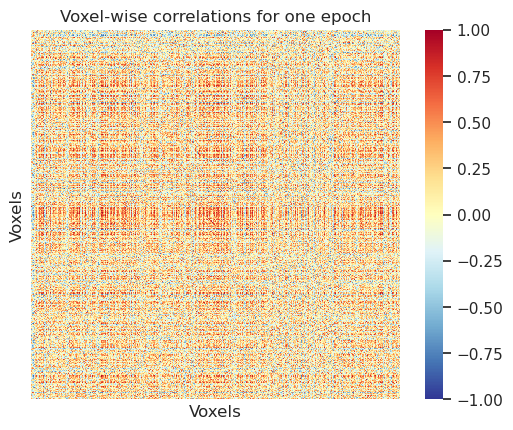

In [8]:
# Extract data for one subject, for one epoch. 
# Then, downsample to take only every 10th voxel.
epoch_data = raw_data[0][:, ::10] # epoch_data now has 12 epochs x 3447 voxels

# Make the data c contiguous (the type of ordering used in C in which the last dimensions are stored first (opposite of fortran/matlab))
mat = np.ascontiguousarray(epoch_data.T, dtype=np.float32)  # Voxels x TRs for one epoch

begin_time = time.time()
epoch_corr = compute_correlation(mat, mat)  # correlation of every voxel with every other voxel
end_time = time.time()
print("Analysis duration: %0.5fs" % (end_time - begin_time))

# This is a different method of visualizing correlation matrices from the 08-connectivity notebook,
# using the Seaborn package. You can use whichever you prefer!
g=sns.heatmap(epoch_corr, vmin=-1, vmax=1, square=True, cmap='RdYlBu_r')
_=g.set(title='Voxel-wise correlations for one epoch', xlabel='Voxels', ylabel='Voxels', yticks=[], xticks=[])


**Exercise 3:**<a id="ex3"></a> What are the inputs to the [compute_correlation](http://brainiak.org/docs/brainiak.fcma.html?highlight=compute_correlation#brainiak.fcma.util.compute_correlation) function? If you instead wanted to compute a epochs-by-epochs correlation matrix, instead of a voxels-by-voxels correlation matrix, which input to `compute_correlation` would you change and how would you change it?

**A:** The input here is two copies of the matrix of voxel intensity by TRs, "mat" to get a correlation map of every voxel to every other voxel. To change this to a epochs by epochs correlation matrix, we'd have to simply not transpose epoch_data when we declare mat

**Voxel selection**

To understand how voxel selection in FCMA works, think back to what we did in notebook 05-classifier-optimization, where we learned different ways to perform cross-validation. When doing cross-validation, one option is to leave out some of your data (such as a run or a participant) while you fit parameters or select voxels. In FCMA, it is typical to perform nested cross-validation in which we leave out a participant for final testing on an outer loop (e.g., participant 18) and perform voxel selection with cross-validation on an inner loop with another participant left out to quantify feature selection performance (e.g., participant 17), and use the rest to conduct feature selection (e.g., participants 1-16). Thus, for each of 18 outer-loop folds, there are 17 inner-loop folds. To use this approach we simply ignore one subject's data before executing the voxel selection procedure (which is the inner loop). We can then use that data for final classifier testing. Then, on new iterations of the outer loop we can rotate which participants are to be ignored.

The inner-loop voxel selection procedure consists of computing correlation matrices and then classification on the correlation patterns. This is highly computationally demanding and has been optimized in BrainIAK, where the [VoxelSelector](http://brainiak.org/docs/brainiak.fcma.html?highlight=voxel%20selector#module-brainiak.fcma.voxelselector) method implements this massive computation, which takes (all voxels by all training subjects by all epochs). How does it work?

1. First, `VoxelSelector` uses the `compute_correlation` function to compute, for each epoch and participant in the training set, the correlation of every voxel with every other voxel in the brain (the full correlation matrix). 
2. For each voxel $v$, it then trains a classifier on a training set consisting of all epochs of voxel $v$ for $n-1$ participants. $v$'s classifier uses the correlation of *v* with each other voxel in the brain as features. 
3. Finally, it tests $v$'s classifier on participant $n$ in the training set. This process is performed for each voxel $v$.

This is repeated for $n$ inner-loop folds of cross-validation and the accuracies are averaged across folds for each voxel. We can then rank voxels in terms of overall performance and use this ranking as a way to select which voxels have discriminative connectivity in the training set.

**Exercise 4:**<a id="ex4"></a> Split the `raw_data` and `labels` variables created by `prepare_fcma_data` into training and testing set. Make subject 1 as the testing set and subjects 2,3 as the training set. Save your data as `raw_data_train`, `labels_train`, `raw_data_test`, and `labels_test`. Print out the shapes of these four variables by uncommenting and running the code provided.

In [9]:
np.shape(raw_data)

(36, 12, 34470)

In [10]:
# Insert code here
raw_data_train = raw_data[12:36]
labels_train = labels
raw_data_test = raw_data[0:12]
labels_test = labels


# Check your work:
print(f'Training data -- raw_data_train : {np.shape(raw_data_train)}, labels_train : {np.shape(labels_train)}')
print(f'Testing data -- raw_data_test : {np.shape(raw_data_test)}, labels_test : {np.shape(labels_test)}')

Training data -- raw_data_train : (24, 12, 34470), labels_train : (36,)
Testing data -- raw_data_test : (12, 12, 34470), labels_test : (36,)


**How FCMA works on a computer or cluster**

The FCMA implementation in BrainIAK efficiently parallelizes and disseminates the computation amongst the resources available. Below is a figure detailing the workflow of FCMA. The figure caption is quoted below:

![image](https://ars.els-cdn.com/content/image/1-s2.0-S0165027015001910-gr1.jpg)
>"Fig. 1. Workflow overview. FCMA uses a controller/worker architecture, in which each worker first loads the full data into memory. The full data consist of a matrix with V voxels in rows and T timepoints in columns; the timepoints can be subdivided into E epochs, each with TE timepoints (inset depicts two voxels and epochs). The controller process does the following: assigns a subset S of voxels to each of W workers; instructs the worker to compute the correlation between each of these voxels and the rest of the brain in each epoch; instructs the worker to analyze the correlation vectors for each voxel across epochs with MVPA and supplied condition labels; collects the analysis result (i.e., cross-validation accuracy) for each voxel and loads it into memory; and returns to the first step to assign another subset of voxels until there are none left. Finally, the controller writes the results to disk." Source:  [Wang et al. (2015)](https://doi.org/10.1016/j.jneumeth.2015.05.012)

This computation cannot be run within a notebook because the controller and worker relationship needs at least two processors to run, but our notebook can only use one processor.

Instead we provide some [batch scripts](#fcma_batch) to execute the whole sequence of the FCMA workflow. However, the code isn't scary and actually does something quite similar to what we have done before with [scikit-learn](http://scikit-learn.org/stable/) for classification: we create a classification object with the inputs we desire, specify the classification kernel and then run it, like this:

`vs = VoxelSelector(labels, epochs_per_subj, num_subjs, raw_data)`  
`clf = SVC(kernel='precomputed', shrinking=False, C=1)`  
`results = vs.run(clf)`  

### 1.5 Create voxel selection masks <a id="masks"></a>

Once we have labels for each voxel representing its average accuracy across inner loop folds, we can then choose how many voxels we wish to include in building our classifier model to test on the final outer-loop test participant. This is a feature selection step just like we did in notebook `05-classifier-optimization`. There we ran a relatively easy feature selection (e.g., with PCA), but here the analyses used to select features are computationally and memory intensive, so we need to save intermediate steps. Regardless, the logic is the same: find the voxels that we think will be most useful in our classification of a held-out, never-before-seen, subject. 

**Note:** We sometimes call the volumes created during feature selection 'masks'. 'Mask' is used to describe a binary volume the shape of our data that can be used to select the voxels we care about. We typically use masks just to select all the brain voxels (i.e., a whole-brain mask) or a specific region of interest, but the logic of masking also applies to feature selection: we can use this volume to pull out only the voxels we want to use for classification. 

The bash script we use here calls [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSL) commands to choose a subset of voxels (top $N$) and create a binary mask for each training set/outer-loop fold. As you should be able to see, it creates three types of files:
1. For each input volume (i.e., participant), a mask for the top $N$ voxels is created (`fc_no${ppt}_result_seq_top${voxel_number}.nii.gz`, where `ppt` is the participant identifier and `voxel_number` is $N$.)
2. These individual masks are then concatenated, resulting in an array in which each element in the 4-D array is a top-$N$-voxel volume mask (`all_top${voxel_number}.nii.gz`).
3. This concatenated array is used to create one map which gives the probability for each voxel to be included in the top *N* voxels (`prop_top${voxel_number}.nii.gz`). i.e., if voxel A is in all participants' masks, then its probability of being in the top $N$ voxels is 1. If voxel B is in 1 out of 10 participants' masks, it will have a value of 0.1.

**Self-study:** Try to understand what happens in the script below. Here are some hints: \${voxel_number} is the number of voxels included. `fslmerge` has the following input structure: `fslmerge -t ${output_name} ${input_1} ${input_2} ... ${input_N}`. The last line that calls `fslmaths` creates the `prop_top` volume by doing a computation on the `all_top` volumes.

In [11]:
!cat ./09-fcma/make_top_voxel_mask.sh

#!/bin/bash 
#
# Takes in a results directory from fcma analysis and a certain number of voxels to threshold for a mask as input

#You will need to load fsl module/conda for your cluster
module load FSL/6.0.5-centos7_64

# Source the FSL config script 
. ${FSLDIR}/etc/fslconf/fsl.sh

# Take inputs
input_dir=$1  # What is the path to the data?
voxel_number=$2  # What voxel threshold are you setting?
output_dir=$3  # Where do you want to put the data?

# Create output_dir
if [ ! -d ${output_dir} ]; then
  mkdir ${output_dir}
fi

# Iterate through each volume in the fcma directory
for file in ${input_dir}/*_seq.nii.gz
do	
	# Preprocess the file name
	fbase=$(basename "$file")
	pref="${fbase%%.*}"
	
	# Create the voxel mask
	fslmaths $file -uthr $voxel_number -bin ${output_dir}/${pref}_top${voxel_number}.nii.gz

done

# Concatenate all of the masks from each volume
fslmerge -t ${output_dir}/all_top${voxel_number} ${output_dir}/fc_no*top${voxel_number}.nii.gz

# Create a probability map of 

### 1.6 Classification <a id="classify"></a>

On this subset of top *N* voxels that we have selected, we perform classification of the correlation patterns by first training on the subjects we used for voxel selection (all participants in the training set) and then testing on the held-out outer-loop participant that wasn't used for any previous analyses.

BrainIAK has a special method, called [Classifier](http://brainiak.org/docs/brainiak.fcma.html?highlight=classifier#module-brainiak.fcma.classifier), that will compute correlations on the selected voxels and perform classification in a computationally efficient manner. We have created the script `fcma_classify.py` as a wrapper. This script is similar to the voxel selection script: data are loaded into memory on each processor, then normalized and prepared for input to FCMA, then a `Classifier` object is made from the data and fit. Like voxel selection, this can be called in a similar way to the classification tools from [scikit-learn](http://scikit-learn.org/stable/).

Critically, the mask input to the `fcma_classify.py` is **not** the whole-brain mask, but instead the `top-N` voxels that are deemed appropriate for this outer-loop fold. In other words, it is only going to leave the voxels in the brain that we have determined carry information.

As before, the code is relatively tractable and familiar; however, again we cannot run this in the notebook because of the need for parallelism. The steps are printed below:

Once our data and labels are arranged into training and test sets we create objects that are ready to be read by FCMA.  If you concatenate the training and testing data then zip it into a single object, this is much more memory efficient. The FCMA code then takes account of how many training samples there are and *never* looks at the test data when fitting the model. This procedure is thus better, although a little harder to understand. 

`training_obj = list(zip(training_data, training_data))`  
`testing_obj = list(zip(testing_data, testing_data))` 

We then create our SVM kernel and Classifier object. You could use many kernels here aside from SVM. This Classifier object is then fit to the training data before being tested on the never-before-seen test data.

`svm_clf = SVC(kernel='precomputed', shrinking=False, C=1)`  
`clf = Classifier(svm_clf, epochs_per_subj=epochs_per_subj)`  
`clf.fit(training_obj, training_labels)`  
`predict = clf.predict(testing_obj)`  


Users of FCMA have found it useful to distinguish between *intrinsic* and *extrinsic* classification: 

> Intrinsic classification, demonstrated above, is when the correlations of only the voxels in the `top_n_mask` are used for classification. In other words this method only cares about correlations among those voxels that were selected because they contain information.  

> Extrinsic classification is when the correlations used for final classification are between voxels within the `top_n_mask` and voxels outside of this mask. In other words this method examines information captured by these nodes with the rest of the brain.

The scripts we provide allow you to specify whether you wish to perform intrinsic or extrinsic FCMA.

### <strong>1.6.1 What is a pre-computed kernel? </strong> <a id="precomputed"></a>

In the above example, we have used a "pre-computed" kernel for the SVM classifier. If you would like to know more about the pre-computed kernel, then read through this section. Otherwise, feel free to move on to the next section. 
 In BrainIAK, setting the kernel as "pre-computed" ensures that BrainIAK computes a kernel (the inner product of the correlation) and then passes it to to SVM for classification. This saves computational time. The mathematical details of kernel methods can be found [here](https://people.eecs.berkeley.edu/~jordan/kernels/0521813972c02_p25-46.pdf). Below, we outline the steps, for training and testing, that BrainIAK has used internally to optimize classification using a pre-computed kernel.


**Definitions**

$N$: The number of voxels in the top $N$ mask. Computing correlations between all voxels will result in ${N}^2$ features for each epoch that we need to classify.  
$ x_i :$ Each training sample with $N$ features. For e.g., for the first epoch, the features are: ${[x_{11}, x_{12},...,x_{1N}]}$; for the second epoch,${[x_{21}, x_{22},...,x_{2N}]}$  
$num\_train$: The number of training samples.     
$num\_test$: The number of testing samples.     

**Training**

1. Compute correlations for each voxel with every other voxel in the `top_N_mask`. Each training sample $x_i$ will have ${N}^2$  features constituting all the correlation values between voxels. We make this a row matrix for each training sample.  
Let's call this matrix $ \mbox{ }Corr $. It is has dimensions $ [num\_train \mbox{ }x \mbox{ } N^2] $ .  

2. In training, the goal is to build a linear classifier that will separate the training samples $ x_i $. This is equivalent to the problem of computing the weight vector as a linear combination of the training samples: 
$$w = sum (\alpha_i * x_i)   $$

Why do we do this step?
Transforming the problem into this linear combination of the training samples is called the dual problem and helps reduce the computational time. Notice that the $\alpha_i$ is written in terms of $G$, the inner product of the correlations of the training samples.  

What is $G$? It is the inner product:
$Corr^T \mbox{ }\cdot Corr$.  
The dimensions of $ Corr $ are $ [num\_train \mbox{ }x \mbox{ } N^2]. $   
Therefore, $G$ must have dimensions $[num\_train \mbox{ }x \mbox{ } num\_train].$

Thus, we now move away from $N^2$ dimensions of $Corr$   to $num\_train^2 $ dimensions via *G*. We know that $num\_train^2 $ is much smaller than $N^2$. This smaller space to work in makes things computationally efficient, and we find the same weights $w$.  This is why we solve the dual problem instead of working with $Corr$.

The $\alpha_i $ are a function of $G$ and a loss parameter $\lambda$. See eqn (2.6) in [kernels](https://people.eecs.berkeley.edu/~jordan/kernels/0521813972c02_p25-46.pdf).

During training, *G* is the *precomputed* kernel. It is computed by taking the inner product of $Corr$ with itself, then it is then passed to the `SVC.fit()` method with the `pre-computed` flag. 

Then, SVC executes to find a good $\alpha_i $ that will best fit the training data.  
At this stage we have built a SVM model and **training is complete**.

**Testing**  
Now we have a new sample $x_{new}$, and we have to predict its class.  
The distance of this sample to the SVM hyperplane is the inner product: $ <w, x_{new}> $.  
In step #2 we wrote $w$ in terms of $\alpha_i \mbox{  } and \mbox{  } x_i $, the training samples. We'll use that here.  
The distance of $x_{new}$ to the hyperplane:  
$ = \mbox{  }  <w, x_{new}> \mbox{  } = sum (\alpha_i * <x_i, x_{new}>).$  

We already know $\alpha_i$: it's what the SVM has  fit from the training data. 

Now simply compute the inner product for the new sample,  $ \mbox{  }k= <x_i, x_{new}> $   
Remember, the $x_i$ are just the training samples. $i =1,2,..., num\_train $  
This $k$ is the *precomputed* kernel for the $x_{new}$ sample during testing.  
The dimensions of $k$ for one test sample is: $[num\_train \mbox{ }x \mbox{ } 1]$.

We pass $k$ to `SVC.predict()` with the `pre-computed` flag and SVC will use the $\alpha_i$ and simply multiply out with $k$ and sum it all up. This is the distance of the point $x_{new}$ from the hyperplane and its class has been predicted.

**Testing is completed for $x_{new}$.**

Now repeat the above testing step for all `test_data`. An efficient method to accomplish this to take all the test samples and make a big $k$ in one sweep, for all test samples, using matrix multiplication. BrainIAK has built-in all the above steps into a fast computation when you specify the *precomputed* option.  

In this case, during testing, the dimensions of the kernel $k$ are: $ [num\_train \mbox{ }x \mbox{ } num\_test]$

**Thus, we do not have to deal with $N^2$ dimensions even during testing.**

More details on using kernels in scikit-learn can be found here: http://scikit-learn.org/stable/modules/svm.html#svm-kernels



## 2. FCMA batch scripts <a id="fcma_batch"></a>

We have covered the main functions needed to run a FCMA analysis. Some of these methods require multiple cores for fast execution and thus cannot be executed from cells in a Jupyter notebook. The scripts are described below.

We are initially going to work with only the first three participants to illustrate feature selection. This could take 20-30 mins on 2 cores. We will then use the results of feature selection for all participants (which we already calculated for you) to perform final classification. 

<div class="alert alert-block alert-warning">
<strong>Note on file paths:</strong> The directories in the scripts point to a specific location and will depend on where you store the scripts and results. The <code>utils</code> script sets up the <code>data_path</code> and <code>results_path</code>  and <code>fs_data_dir/output_dir</code> are based on this. Please ensure this is appropriate.
</div>

**./09-fcma/run_fcma_voxel_selection_cv.sh**<a id="fcma_voxel_sel"></a> 

This bash script sets up the job and runs *./09-fcma/fcma_voxel_selection_cv.py*, which loads in and formats the [fMRI](#data_prep) and [epoch](#epoch) data, [performs normalization](#prep_for_fcma), and [VoxelSelection](#vox_sel). The bash script takes in six inputs:
1. `data_dir`=What is the directory containing data?  
    - e.g. `${fs_data_dir}`
2. `suffix`=What is the extension of the data you're loading (i.e., the ending of the filename)  
    - e.g. `bet.nii.gz`  
3. `mask_file`=What is the path to the whole brain mask 
    - e.g. `${fs_data_dir}/mask.nii.gz`
4. `epoch_file`=What is the path to the epoch file 
    - e.g. `${output_dir}/fs_epoch_labels_3subj.npy`
5. `left_out_subj`=Which participant (as an integer) are you leaving out for this cv? 
    - e.g. `0`
6. `voxel_selection_dir`=Where do you want to save the data.
    - e.g. `${output_dir}/voxel_selection_subsample`

**./09-fcma/make_top_voxel_mask.sh**<a id="top_vox_mask"></a>  

This script uses FSL to create a [binary mask](#masks) of the top N voxels for each file generated by voxel selection. This creates a mask for each participant and then aggregates the masks. This takes the following inputs:
1. voxel_selection_dir=What is the path to the voxel selection results?
   - e.g. `${output_dir}/voxel_selection_subsample/`
2. voxel_number=How many top voxels $N$ do you want to select?
   - e.g. `100`
3. mask_dir=Where do you want to save the masks?
   - e.g. `${output_dir}/top_n_masks_subsample/`

**./09-fcma/run_fcma_classify.sh**<a id="fcma_classify"></a>  

This runs *fcma_classify.py* which performs [classification](#classify) of the voxels selected by VoxelSelection, using the *Classifier* object. This takes the following inputs:
1. data_dir=What is the directory containing data? 
   - e.g. `${fs_data_dir}`
2. suffix=What is the extension (i.e., the ending of the filename) of the data you're loading?
   - e.g. `bet.nii.gz`
3. top_n_mask_file=What is the path to the top N mask file (*this is not the whole-brain mask*)
   - e.g. `${output_dir}/top_n_masks_all/fc_no0_result_seq_top100.nii.gz`
4. epoch_file=What is the path to the epoch file 
   - e.g. `${output_dir}/fs_epoch_labels_3subj.npy`
5. left_out_subj=Which participant (as an integer) are you using for testing? 
   - e.g. `0`
6. second_mask=Do you want to use a second mask to compare the data with? Necessary for extrinsic analyses, otherwise set to None. For instance, if you want to do a whole-brain extrinsic analysis (correlating all voxels in the mask with those outside of the mask) then you would specify the path to the whole-brain mask here.
   - e.g. `None`

### 2.1 Inner loop (three subjects)<a id="fcma_inner"></a>

Although the FCMA tools have greatly sped up the computation time required for these analyses, it still takes a long time to compute a trillion (that's 1,000,000,000,000) correlations, as is needed for voxel selection with this dataset. Hence we are only going to run voxel selection on three participants for now.

<div class="alert alert-block alert-warning"> <strong> Bash scripting </strong><a id="bash"></a>
<br>
In previous notebooks we have used some bash commands to submit jobs or to query some data using command line tools. We can use bash commands in jupyter by starting a line with an `!` or by putting the %%bash magic at the top of a cell. However, most bash scripting is done in the command line.
<br>
Below you are going to need to use a lot of bash scripting. There are <a href="https://linuxconfig.org/bash-scripting-tutorial-for-beginners">numerous</a> <a href="https://www.geeksforgeeks.org/bash-scripting-introduction-to-bash-and-bash-scripting/">tutorials</a> 
<a href="https://www.howtogeek.com/67469/the-beginners-guide-to-shell-scripting-the-basics/">available</a> online to teach you the basics. For what we will be doing here, there are a couple of critical functions:
<br>
<br>
- <code>cat</code>: this will print the content of a file. For instance, <code>cat ./make_top_voxel_mask.sh</code> will print out this file  <br>
- <code>ls</code>: will print out the contents of a directory. For example, <code>ls logs/</code> will print the content of your log directory.   <br>    
- <code>vim</code>: This will open a GUI text editor that is pretty easy to use. For example, <code>vim ./run_fcma_classify.sh</code> will allow you to edit this function. <bold>**In jupyterlab, you can also open files from your file browser and edit them as normal text files.</bold>** <br>
- <code>for ...; do ...; done</code>: run a for loop. For instance, <code>for i in `seq 1 5`; do echo $i; done</code> will print the numbers 1 to 5.<br>

You will also likely need to define variables in your terminal session if you don't want to copy/paste long paths multiple times! If you are uncertain how to do this, see <a href="https://www.shellscript.sh/variables1.html">here</a>. To check if variables are defined in your terminal session, you can use <code>echo</code>. For example, if I want to see how I defined <code>output_dir</code>, I could run: <code>echo ${output_dir}</code>.
</div>

**Exercise 5:**<a id="ex5"></a> Perform the following steps for your sample of three participants:  
1. Check that you created the epoch file with the first three participants in [Exercise 1](#ex1) and saved it at `{output_dir}/fs_epoch_labels_3subj.npy`. 
2. From the terminal, run the voxel selection from the 09-fcma folder (your submission call will look something like: `sbatch ./run_fcma_voxel_selection_cv.sh $data_dir $suffix $mask_file $epoch_file $left_out_subj $output_dir` **after** you have defined all the input arguments!), for each participant, leaving one of the participants out each time. You can use the inputs specified [above](#fcma_voxel_sel) *as examples*, but you may need to adjust them! **Please paste the commands you ran in the corresponding cell below.** <br>
3. When step 2 is finished: create a mask of the top **100** voxels using `./make_top_voxel_mask.sh $input_dir $voxel_number $output_dir`. You can use the inputs specified [above](#top_vox_mask) as examples, but you may need to adjust them! **Again, please paste in the corresponding cell the command you ran.** This will only take seconds. Remember that this script uses [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSL) functions. Thus, it will only work if you have set up and sourced [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSL) as outlined in the script. <br>
4. Plot the masks of the top **100** voxels for each participant (saved in `${output_dir}/top_n_masks_subsample/`) using the [nilearn.plotting](https://nilearn.github.io/dev/plotting/index.html) tools. Plot one map per participant and add a title to each plot with the participant's number.   

**Helpful tips:** <br>
* Running the `run_fcma_vosel_selection_cv.sh` script can take ~15-30 minutes with the default configuration. *It may take longer if you are running your scripts at the same time as everyone else in class. Thus, start early!*<br>
* You must be very careful to provide the right command-line arguments to your scripts. *Do not just copy/paste the provided command outlines; these are examples, and you will need to define your own path names!* Use the resources provided in the yellow box [Bash scripting](#bash) to help you define command-line argument.<br> 
* If you have trouble running your scripts, your first step should be to check your command line arguments -- most errors occur here!
* We suggest you first run the job for one participant, make sure it works (checking your output directory to make sure results appear!) before running the job for the other two participants.
* You can check on your jobs with `seff $JID`, where `$JID` is the job id that you got when you submitted this script. You should also check the log file created for your job, by opening it in the file browser (in the 09-fcma/log/{JID}-fvma_voxel_select_cv.out).
* You can continue on to the following exercises while this runs. They do not rely upon these results.

In [12]:
epoch_file

'/gpfs/gibbs/project/cmhn/data/face_scene/fs_epoch_labels.npy'

**Paste step 2 commands here... NOTE THAT DOLLAR SIGNS PRECEEDING VARIBALES WHEN A SCRIPT IS CALLED WERE INLUDED IN THE TERMINAL BUT NOT HERE AS THEY WOULD CAUSE FORMATTING ISSUES** 

data_dir=/gpfs/gibbs/project/cmhn/data/face_scene/

suffix=bet.nii.gz

mask_file=/gpfs/gibbs/project/cmhn/data/face_scene/mask.nii.gz

epoch_file=/gpfs/gibbs/project/cmhn/data/face_scene/fs_epoch_labels_3subj.npy

run 1:
left_out_subj=0

run 2:
left_out_subj=1

run 3:
left_out_subj=2

voxel_selection_dir=/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/voxel_selection_subsample

sbatch ./run_fcma_voxel_selection_cv.sh data_dir suffix mask_file epoch_file left_out_subj output_dir

In [13]:
fs_data_dir

'/gpfs/gibbs/project/cmhn/data/face_scene/'

**Paste step 3 commands here**

input_dir=/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/voxel_selection_subsample/

voxel_number=100

output_dir=/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/top_n_masks_subsample/

./make_top_voxel_mask.sh (dollar sign)input_dir  (dollar sign)voxel_number (dollar sign)output_dir

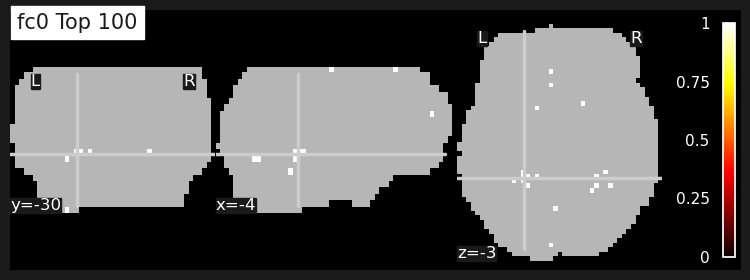

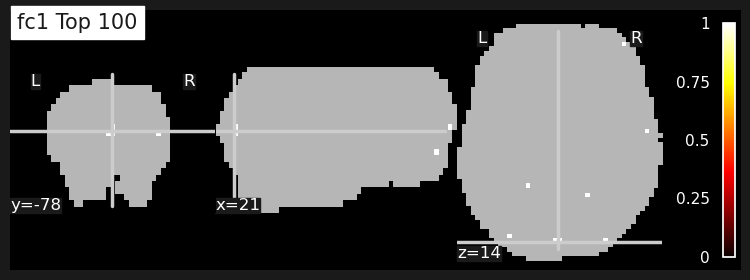

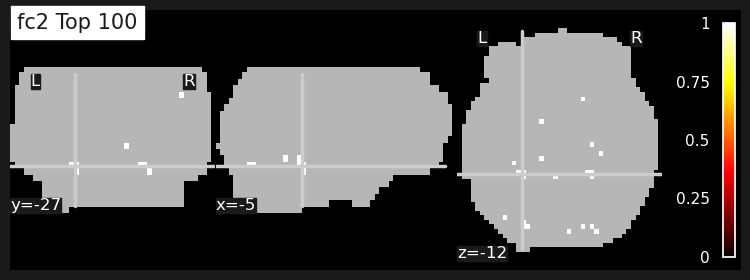

In [34]:
# Insert code for step 4 here
fc0_top100 = "/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/top_n_masks_subsample/fc_no0_result_seq_top100.nii.gz"
fc1_top100 = "/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/top_n_masks_subsample/fc_no1_result_seq_top100.nii.gz"
fc2_top100 = "/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/top_n_masks_subsample/fc_no2_result_seq_top100.nii.gz"

background_image = "/gpfs/gibbs/project/cmhn/data/face_scene/mask.nii.gz"

# Nilearn has useful tools for plotting our results as a map
plotting.plot_stat_map(
     fc0_top100,bg_img =background_image,title="fc0 Top 100"
)
plotting.plot_stat_map(
     fc1_top100,bg_img =background_image,title="fc1 Top 100"
)
plotting.plot_stat_map(
     fc2_top100,bg_img =background_image,title="fc2 Top 100"
)

### 2.2 Outer loop (all subjects)<a id="fcma_outer"></a>

The above exercise was to familiarize you with how the voxel selection step works. This step was slow because we are calculating the full correlation matrix and a separate cross-validation is performed for every voxel's connectivity. However, the outer loop is relatively fast, at least for intrinsic analyses, because we are only training and testing on a subset of voxels. Hence we will use voxel selection data we prepared earlier for you (`${fs_data_dir}/voxel_selection_all/`) to run the outer loop, aka final classification, for each participant.

In [15]:
fs_data_all_ready= f'{fs_data_dir}voxel_selection_all/'

In [16]:
fs_data_all_ready

'/gpfs/gibbs/project/cmhn/data/face_scene/voxel_selection_all/'

In [17]:
output_dir

'/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results'

**Exercise 6:**<a id="ex6"></a> Create a mask of the top **1500** voxels using the `make_top_voxel_mask.sh` script. Use the `${fs_data_all_ready}` folder as an input and `${output_dir}/top_n_masks_all` as the output destination (again, check that these variables are defined in your terminal session - do not just copy/paste!). Paste the command you use to submit this below. Then, use nilearn's stat map plotting to plot the map that shows the probability of each voxel being included in the top 1500 across all participants. Use the `{fs_data_dir}/mask.nii.gz` file as the background image if you need. 

**Paste commands here**

input_dir=/gpfs/gibbs/project/cmhn/data/face_scene/voxel_selection_all/

voxel_number=1500

output_dir=/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/top_n_masks_all

./make_top_voxel_mask.sh (dollar sign)input_dir (dollar sign)voxel_number (dollar sign)output_dir

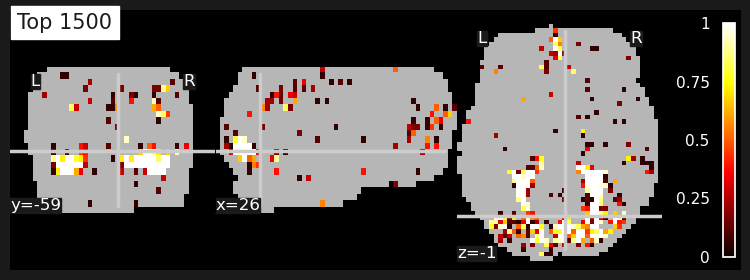

In [33]:
# Insert plotting code here.
top1500 = "/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/top_n_masks_all/prop_top1500.nii.gz"
background_image = "/gpfs/gibbs/project/cmhn/data/face_scene/mask.nii.gz"
# Nilearn has useful tools for plotting our results as a map
plotting.plot_stat_map(
     top1500,bg_img =background_image,title="Top 1500"
)

**Exercise 7:**<a id="ex7"></a> Perform *intrinsic* classification on **all participants** using the `run_fcma_classify.sh` script. This performs the outer-loop classifier for a single held-out participant, so you need to loop through all subjects, making sure to change the voxel selection mask (top_n_mask_file) for each subject. An example call to this script would be:

`sbatch ./run_fcma_classify.sh $data_dir $suffix $top_n_mask_file $epoch_file $left_out_subj $second_mask` 

You can use the example inputs specified [above](#fcma_classify), making sure to update them as needed. The accuracies will be saved in a file called `classify_result.txt` in the output folder. Once this has finished, read in `classify_result.txt` (preferably by opening a text-file reader in python and reading in the results) and print out the average and standard deviation of the accuracies across the 18-outer folds. 

**Note: make sure to change your voxel selection mask and left-out test subject on each loop. Also make sure to use an epoch file that has all 18 subjects, as opposed to the file you generated with just the first 3!**


In [19]:
fs_data_dir

'/gpfs/gibbs/project/cmhn/data/face_scene/'

In [20]:
output_dir

'/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results'

In [21]:
epoch_file

'/gpfs/gibbs/project/cmhn/data/face_scene/fs_epoch_labels.npy'

data_dir=/gpfs/gibbs/project/cmhn/data/face_scene/
suffix=bet.nii.gz
epoch_file=/gpfs/gibbs/project/cmhn/data/face_scene/fs_epoch_labels.npy  
second_mask=None


for i in 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17

do

top_n_mask_file=/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/top_n_masks_all/fc_no${i}_result_seq_top1500.nii.gz

left_out_subj=${i}

sbatch ./run_fcma_classify.sh data_dir suffix top_n_mask_file epoch_file left_out_subj second_mask

done

In [22]:
# Code here
accuracy = []
with open("/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/classify_result.txt", "r") as f:
    for line in f:
        num = line.strip().split(':')[1]
        accuracy.append(float(num.strip()))
print(f"the average is {np.mean(accuracy)} and the standard deviation is {np.std(accuracy)}")

the average is 0.9027777777777778 and the standard deviation is 0.11197580205970209


**Exercise 8:**<a id="ex8"></a> Run this classification step without the precomputed kernel, instead using the default linear SVM. To do this, you need to do the following: 
1. Make a new file called `fcma_classify_linear.py` based off `fcma_classify.py` in the 09-fcma directory.<br>
    1A. Change `svm_clf = SVC(kernel='precomputed', shrinking=False, C=1)` to `svm_clf = SVC(shrinking=False, C=1)` in your new file.<br>
    1B. Change the output file, which is specified in line 48: 
    `output_file = results_path + '/classify_result_linear.txt'`.<br>
    1C. Change the `is_memory_efficient` variable specified on line 47 to 0, otherwise the linear kernel will not work.<br>
    1D. Change the SVC call to not use the precomputed kernel. See section [1.6](#classify) for more details.<br>

2. Make a new run file called `run_fcma_classify_linear.sh` by copying the `run_fcma_classify.sh`.<br>
    2A. Change the function called in the script to reference this new `fcma_classify_linear.py` script.<br>
    2B. Allocate more memory for this job (since the precomputed kernel was more memory efficient) by changing `#SBATCH --mem-per-cpu` to `#SBATCH --mem-per-cpu=6G`<br>
    2C. Run this script with the appropriate input arguments.<br>

**Self-Study** If you are curious about what the `shrinking` option means, check [this link](https://stats.stackexchange.com/questions/24414/svm-options-in-scikit-learn).


What is the average accuracy and standard error of this new classifier? How does the accuracy compare to the precomputed analysis? Compare the run times for pre-computed vs. standard kernels - which takes longer and by how much?   
*Hint: you can check run times by either viewing the log files for a more verbose output* (`cat log/${JOBID}_fcma_classify.out`) *or using seff for a concise summary of runtime parameters* (`seff ${JOBID}`). *Make sure you use the appropriate* `$JOBID` *for each task.* 

In [30]:
# Insert code here
accuracylin = []
with open("/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/classify_result_linear.txt", "r") as f:
    for line in f:
        num = line.strip().split(':')[1]
        accuracylin.append(float(num.strip()))
print(f"the average is {np.mean(accuracylin)} and the standard deviation is {np.std(accuracylin)} and the standard error is {np.std(accuracylin, ddof=1) / np.sqrt(np.size(accuracylin))}")

the average is 0.855072463768116 and the standard deviation is 0.143745176991865 and the standard error is 0.030646574707329635


The accuracy is 0.855 and standard error is 0.0307. Accuracy lower in the new classifier compared to the old one and the new classifier takes around 4 times as much time to complete even with additional computing resources

## 3. Plotting the results <a id="plot"></a>

As always, it is useful to visualize our results to get an idea of where in the brain contains information. However, in the case of FCMA, remember the information isn't localized to a voxel but instead is captured in the relationship between voxels. Hence we typically want to plot a connectome rather than a heatmap. Fortunately, as you might remember from last notebook, there are great tools for plotting [connectomes](http://nilearn.github.io/modules/generated/nilearn.plotting.plot_connectome.html) in nilearn. These tools work with data in MNI space, but the plots can be uninformative if the number of nodes is very large and this data is not in MNI space. An alternate visualization tool we will use is the Circos plot. 


### 3.1 Compute correlation for mask <a id="corr-mask"></a>

First, we are going to load in a mask that we have created and then compute correlations of every voxel in the mask with every other voxel in the mask (intrinsic). 

In [44]:
# Load in the data
epoch_data = raw_data[0] # Just load a single subject and a single epoch
mask_top_n_file = os.path.join(output_dir,'top_n_masks_all/fc_no0_result_seq_top1500.nii.gz')
mask_top_n_nii = nib.load(mask_top_n_file)  # Load the mask that leaves that participant out
mask_top_n = mask_top_n_nii.get_data()

# Convert the top n mask into a vector with the same number of elements as the whole brain
mask_vec = mask.reshape(np.prod(mask.shape))
mask_top_vec = mask_top_n.reshape(np.prod(mask_top_n.shape))[mask_vec]

# Mask the epoch data
epoch_data_masked = epoch_data[:, mask_top_vec==1]

# Make the data c continguous 
epoch_data_masked = np.ascontiguousarray(epoch_data_masked.T, dtype=np.float32)

# Create the internal correlation
epoch_corr = compute_correlation(epoch_data_masked, epoch_data_masked)

# Pull out the coordinates of the mask (in numpy space)
coord_x, coord_y, coord_z = np.where(mask_top_n == 1)

# Convert from the input space into the same space as the mask_top_n_nii file

coords = coord_transform(coord_x, coord_y, coord_z, mask_top_n_nii.affine)

# Save for later
plot_out_dir = os.path.join(output_dir, 'plotting_out')
if not os.path.exists(plot_out_dir):
    os.makedirs(plot_out_dir)
np.save(os.path.join(plot_out_dir,"epoch_corr"), epoch_corr)
np.save(os.path.join(plot_out_dir,"epoch_corr_coords"), coords)

### 3.2 Plotting Circos <a id="circos"></a>

If someone tells you that science isn't art then that person has never seen a circos plot:

**Self-study:** This [website](http://mkweb.bcgsc.ca/tableviewer/visualize/) allows you to upload a table of data and make a circos plot. If you would like, you can use the script below to save a correlation matrix as a table that can be read into the website. You could then upload that into your git repo and render it in this notebook or you could download the file directly from the repo. Mileage may vary with the website but when it works, it is great. Note that you cannot have a matrix that is bigger than 75 * 75 so figure out how to select your data first.

In [25]:
# Print circos compatibile information
fid = open('./09-fcma/circos_table.txt', 'w')
for voxel_row in range(epoch_corr.shape[0]):
    
    # Do something different for the first row
    if voxel_row == 0:
        line = 'Labels\t'

        for voxel_col in range(epoch_corr.shape[1] - 1):
            line += "vox_" + str(voxel_col) + '\t'
    else:
        
        # Pull out the label and the content of the first line
        line = "vox_" + str(voxel_row -1) + '\t'
        for voxel_col in range(epoch_corr.shape[1]):
            weight = int(abs(epoch_corr[voxel_row - 1, voxel_col]*100))  # Must be positive integers
            line += str(weight) + '\t'
    
    # Write the line you have prepared
    fid.write(line + '\n')

# Close the text file that was created
fid.close()

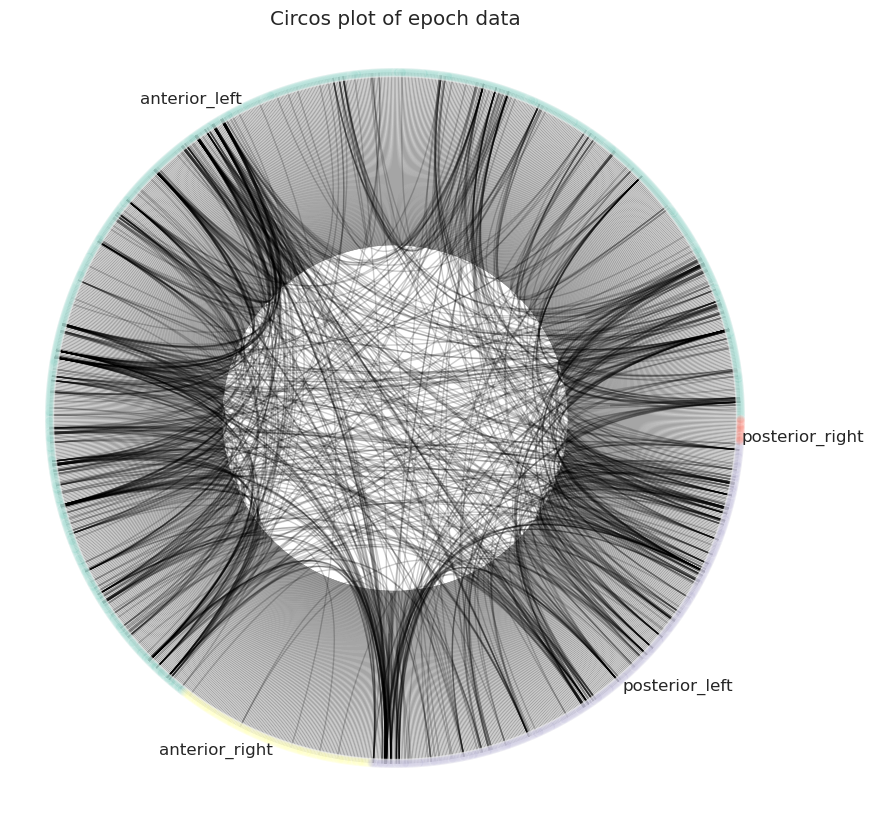

In [55]:
from nxviz import annotate
from nxviz.utils import node_table, edge_table

# What is the (absolute) correlation threshold?
threshold = 0.95

# Load in the data
plot_out_dir = os.path.join(output_dir, 'plotting_out')
epoch_corr = np.load(os.path.join(plot_out_dir,"epoch_corr.npy"))
epoch_coords = np.load(os.path.join(plot_out_dir,"epoch_corr_coords.npy"))

# Preset the graph
G = nx.Graph()

# Create the edge list
nodelist = []
edgelist = []
for row_counter in range(epoch_corr.shape[0]):
    nodelist.append(str(row_counter))  # Set up the node names
    
    for col_counter in range(epoch_corr.shape[1]):
        
        # Determine whether to include the edge based on whether it exceeds the threshold
        if abs(epoch_corr[row_counter, col_counter]) > threshold:
            # Add a tuple specifying the voxel pairs being compared and the weight of the edge
            edgelist.append((str(row_counter), str(col_counter), {'weight': epoch_corr[row_counter, col_counter]}))
        
# Create the nodes in the graph
G.add_nodes_from(nodelist)

# Add the edges
G.add_edges_from(edgelist)

# Set the colors and grouping (specify a key in a dictionary that can then be referenced)
for n, d in G.nodes(data=True):
    
    # Is the x coordinate negative (left)
    if epoch_coords[0][int(n)] < 0:
        if epoch_coords[1][int(n)] < 0:
            G.nodes[n]['grouping'] = 'posterior_left'
        else:
            G.nodes[n]['grouping'] = 'posterior_right'
    else:
        if epoch_coords[1][int(n)] < 0:
            G.nodes[n]['grouping'] = 'anterior_left'
        else:
            G.nodes[n]['grouping'] = 'anterior_right'

# Render the plot
fig,ax=plt.subplots(figsize=(10,10))
nv.circos(G, group_by='grouping', node_color_by='grouping', node_enc_kwargs={"size_scale":6, 
                                                                            "alpha_scale":0.2,
                                                                            'alpha_bounds':(0,0.8), 
                                                                            'zorder':2})
annotate.circos_group(G, group_by="grouping")
plt.title('Circos plot of epoch data', fontsize='large');

## 4. MVPA and FCMA<a id="mvpa"></a>

We are now ready to compare the results from FCMA with that from MVPA on this face-scene dataset. FCMA gives us an unbiased, data-driven view of the connectivity between voxels while subjects attend to faces and scenes. We had conjectured that MVPA will fail to highlight brain regions that show similar activity patterns to both conditions. A candidate brain region that might show similar activity patterns while attending to faces and scenes is the pre-frontal cortex. This is a region that changes its selectivity based on the items attended ([Cukur et al., 2013](https://www.ncbi.nlm.nih.gov/pubmed/23603707)) and hence would be hard to decode across the two conditions in the face-scenes experiment.

We already performed searchlight analysis in a previous notebook (07-searchlight) on this dataset, using leave-one-subject-out classification on activity patterns. We can compare the results from that analysis with our results from FCMA.

**Exercise 9:**<a id="ex9"></a> Compare the MVPA accuracy map and the 5000 voxels identified by FCMA to be involved in attending to faces/scenes.  Make sure you run the `make_top_voxel_mask.sh` again with voxel_number=5000 first for the FCMA analysis. Then, load in the average image created here (prop_top5000.nii.gz) and compare it with the average image used in week 07 (in your prior repository, $WEEK7_DIR/07-searchlight/avg18_whole_brain_SL.nii.gz). Visualize the two maps and label them appropriately. Threshold them both at the same intensity and use the same cut coordinates. What do you see? 

input_dir=/gpfs/gibbs/project/cmhn/data/face_scene/voxel_selection_all/

voxel_number=5000

output_dir=/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/top_n_masks_all5000

./make_top_voxel_mask.sh (dollar sign)input_dir (dollar sign)voxel_number (dollar sign)output_dir

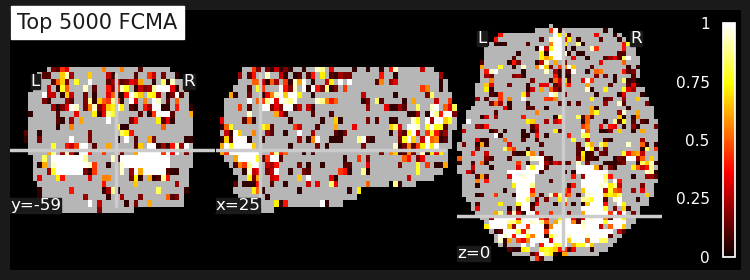

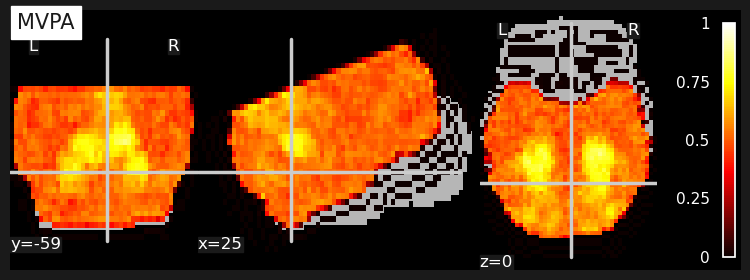

In [43]:
# Plot your results
top5000 = "/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/top_n_masks_all5000/prop_top5000.nii.gz"
background_image = "/gpfs/gibbs/project/cmhn/data/face_scene/mask.nii.gz"
# Nilearn has useful tools for plotting our results as a map
plotting.plot_stat_map(
     top5000,bg_img = background_image,title="Top 5000 FCMA", cut_coords = (25,-59,0)
)
MVPA = "/home/cmhn_ak2776/cmhn-s23-week07-searchlight-ajkohl/07-searchlight/avg18_whole_brain_SL.nii.gz"
background_image = "/gpfs/gibbs/project/cmhn/data/face_scene/mask.nii.gz"
# Nilearn has useful tools for plotting our results as a map
plotting.plot_stat_map(
     MVPA,bg_img =background_image,title="MVPA", cut_coords = (25,-59,0), vmax = 1
)

In all but especially the axial view, we see a high amount of similarity between the voxels identified by MVPA and the voxels identified by FCMA. This makes sense as the excess noise and extra voxels labeled as relevent by MVPA are likely voxels that show similar activity patterns to both face and scene conditions, while FCMA is better at distinguishing and providing a more accurate view of connectivity without the erroneous bias seen in MVPA.

**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

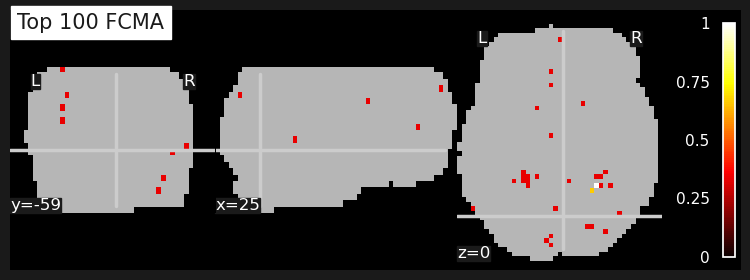

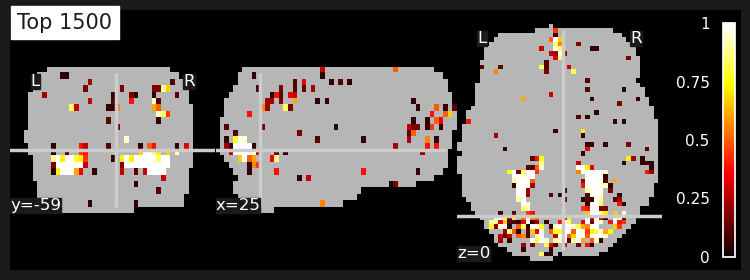

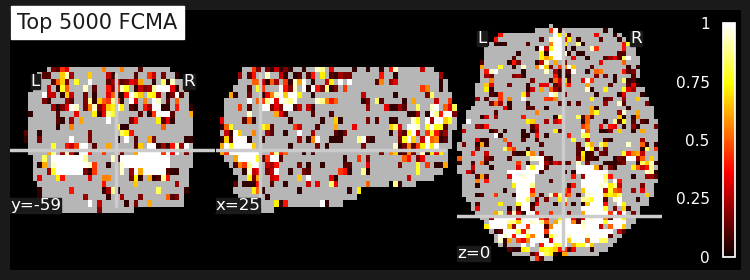

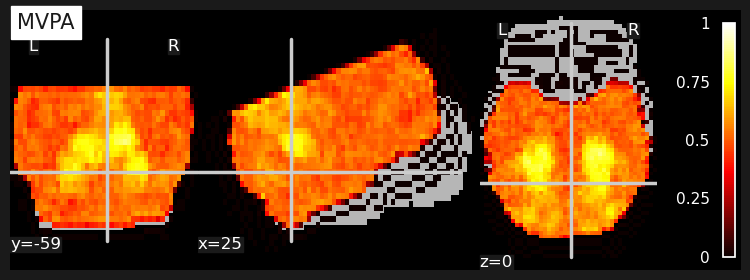

In [54]:
# Plot your results
top100 = "/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/prop_top100.nii.gz"
background_image = "/gpfs/gibbs/project/cmhn/data/face_scene/mask.nii.gz"
# Nilearn has useful tools for plotting our results as a map
plotting.plot_stat_map(
     top100,bg_img = background_image,title="Top 100 FCMA", cut_coords = (25,-59,0)
)

# Insert plotting code here.
top1500 = "/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/top_n_masks_all/prop_top1500.nii.gz"
background_image = "/gpfs/gibbs/project/cmhn/data/face_scene/mask.nii.gz"
# Nilearn has useful tools for plotting our results as a map
plotting.plot_stat_map(
     top1500,bg_img =background_image,title="Top 1500", cut_coords = (25,-59,0)
)

# Plot your results
top5000 = "/home/cmhn_ak2776/palmer_scratch/brainiak_results/fcma_results/top_n_masks_all5000/prop_top5000.nii.gz"
background_image = "/gpfs/gibbs/project/cmhn/data/face_scene/mask.nii.gz"
# Nilearn has useful tools for plotting our results as a map
plotting.plot_stat_map(
     top5000,bg_img = background_image,title="Top 5000 FCMA", cut_coords = (25,-59,0)
)

MVPA = "/home/cmhn_ak2776/cmhn-s23-week07-searchlight-ajkohl/07-searchlight/avg18_whole_brain_SL.nii.gz"
background_image = "/gpfs/gibbs/project/cmhn/data/face_scene/mask.nii.gz"
# Nilearn has useful tools for plotting our results as a map
plotting.plot_stat_map(
     MVPA,bg_img =background_image,title="MVPA", cut_coords = (25,-59,0), vmax = 1
)

Comparing these, we can confirm that the data acquired from the limited set of 3 that we used to acquire the top 100 voxels in exercise 5 genereted results that provided an innacurate general probability of the voxels being in the top 100. Although certain voxel masks identified do fit within the later confirmed high connectivity voxels, others are not, and there are certain empty spots on the plot corresponding to some very bright areas in the later visualizations. Hence we see that a comprehensive dataset is necessary

## Contributions <a id="contributions"></a>

B. Hutchinson provided data  
B. Hutchinson and Y. Wang provided initial code  
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 3/27/18   
H. Zhang added more exercises, solutions, ran full dataset, novel contribution ideas, other edits  
M. Kumar added description for pre-computed kernel.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented updates from cmhn-s19.   
E. Busch updates for chmn-s22, integrated new api for circos, updates for cmhn-s23 and Grace cluster.